# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

The preprocessed data set can be downloaded from http://file.biolab.si/opentsne/benchmark/macosko_2015.pkl.gz.

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [6]:
%%time
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 8.72 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.58 seconds
CPU times: user 31 s, sys: 1.63 s, total: 32.7 s
Wall time: 14.1 s


**2. Generate initial coordinates for our embedding**

In [7]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 742 ms, sys: 418 ms, total: 1.16 s
Wall time: 213 ms


**3. Construct the `TSNEEmbedding` object**

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)

**4. Optimize embedding**

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12)

===> Running optimization with exaggeration=12.00, lr=2501.75 for 250 iterations...
Iteration   50, KL divergence 5.1633, 50 iterations in 2.3390 sec
Iteration  100, KL divergence 5.0975, 50 iterations in 2.5052 sec
Iteration  150, KL divergence 5.0648, 50 iterations in 2.3208 sec
Iteration  200, KL divergence 5.0510, 50 iterations in 2.3077 sec
Iteration  250, KL divergence 5.0430, 50 iterations in 2.3200 sec
   --> Time elapsed: 11.79 seconds
CPU times: user 31.7 s, sys: 343 ms, total: 32.1 s
Wall time: 11.9 s


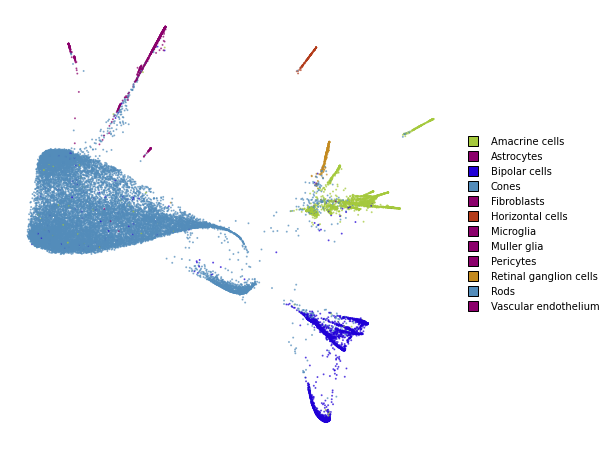

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=500)

===> Running optimization with exaggeration=1.00, lr=30021.00 for 500 iterations...
Iteration   50, KL divergence 3.0008, 50 iterations in 2.4008 sec
Iteration  100, KL divergence 2.7927, 50 iterations in 3.6000 sec
Iteration  150, KL divergence 2.6962, 50 iterations in 4.8722 sec
Iteration  200, KL divergence 2.6384, 50 iterations in 6.0994 sec
Iteration  250, KL divergence 2.5970, 50 iterations in 7.2336 sec
Iteration  300, KL divergence 2.5673, 50 iterations in 8.3499 sec
Iteration  350, KL divergence 2.5431, 50 iterations in 9.6641 sec
Iteration  400, KL divergence 2.5244, 50 iterations in 10.8648 sec
Iteration  450, KL divergence 2.5088, 50 iterations in 11.8919 sec
Iteration  500, KL divergence 2.4950, 50 iterations in 13.4849 sec
   --> Time elapsed: 78.46 seconds
CPU times: user 1min 58s, sys: 442 ms, total: 1min 58s
Wall time: 1min 18s


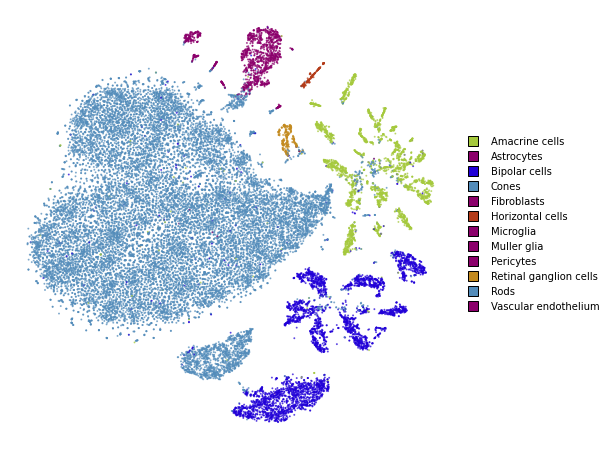

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

## Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(x_test)

===> Finding 90 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 3.86 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.17 seconds
CPU times: user 10.8 s, sys: 713 ms, total: 11.5 s
Wall time: 4.06 s


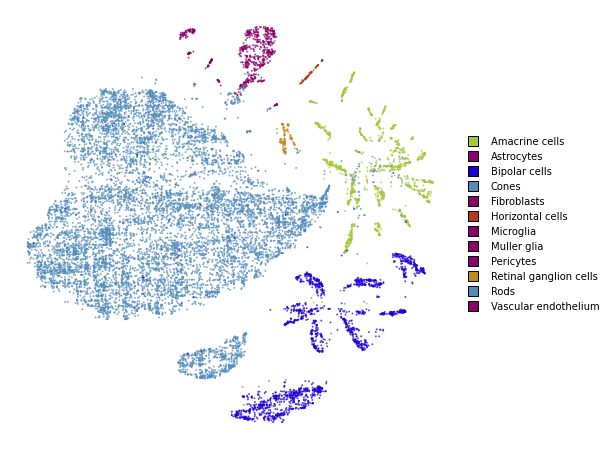

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%time embedding_test_1 = embedding_test.optimize(n_iter=250, learning_rate=0.1, exaggeration=1.5)

===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 207802.1491, 50 iterations in 0.4943 sec
Iteration  100, KL divergence 203381.3331, 50 iterations in 0.4801 sec
Iteration  150, KL divergence 199053.2098, 50 iterations in 0.4745 sec
Iteration  200, KL divergence 197220.9429, 50 iterations in 0.5029 sec
Iteration  250, KL divergence 196404.5606, 50 iterations in 0.4917 sec
   --> Time elapsed: 2.44 seconds
CPU times: user 7.87 s, sys: 113 ms, total: 7.98 s
Wall time: 3.24 s


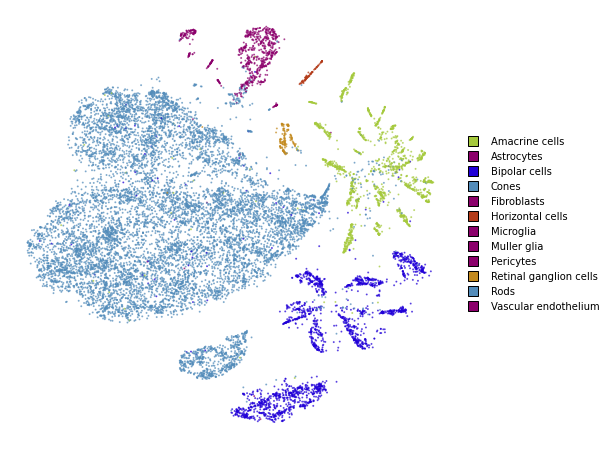

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

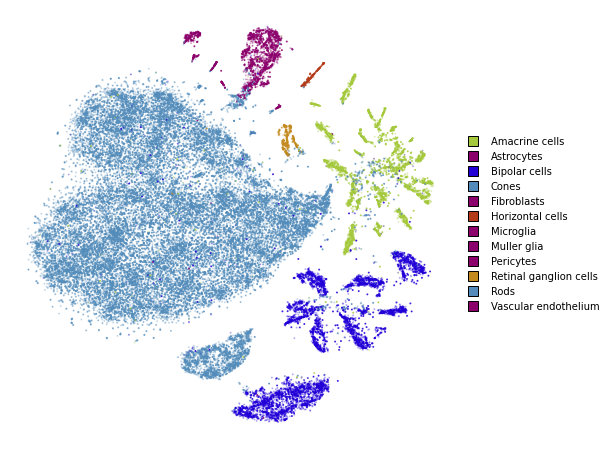

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)